## Case Introduction and Objective

* Determine a classifying method to detect Oscar members that are not receiving their required medical care as well as to identify Oscar members with highly unusual care patterns based on their dignosis data and prescription drug usage data

## Three major characterizations:

1. 'Received enough medical cares'
2. 'Did not receive enough medical cares'
3. 'Unusual pattern that requires additional investigation'

## Questions to think about for requirement 1
* How to define whether receive enough medical cares?
    * given the amount of diag claims, does the member receive enough medications? - not used
    * given the categories of diag claims, does the member recieve enough categories of drugs? - used


* How to define highly unusual care patterns?
    * abnormal amount of diagnosis claims (Outliers) - not used 
    * abnormal amount of prescriptions (Outliers) - not used
    * abnormal amount of combination of diag+drugs (proportion outliers) - used

## Dataset Descriptions and Highlighted Variables
* Members' claim lines with diagnosis codes
    * member id
    * service date
    * diag1: diag code
* Clinical categories (CCS) mapping to the first dataset
    * diag: diag code
    * diag_desc: description of the diagnosis
    * ccs_1_desc: general category of that disease
    * ccs_2_desc: more detailed description derived from ccs_1_desc
    * ccs_3_desc: more detailed description derived from ccs_2_desc 
* Members' prescription drug data
    * member id
    * service date
    * ndc: drug code
    * drug category

In [376]:
### import libraries for data loading and exploration
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [95]:
### loading three datasets
diag_data = pd.read_csv('claim_lines.csv')
ccs_data = pd.read_csv('ccs.csv')
drug_data = pd.read_csv('prescription_drugs.csv')

In [96]:
### define a function to get an initial understanding of the data
def summary_data(data):
    print('-' * 38+'Head'+'-' * 39)
    print(data.head(3))
    print('-' * 38+'shape'+'-' * 38)
    print(data.shape)
    print('-' * 38+'info'+'-' * 38)
    print(data.info())
    print('-' * 38+'describe'+'-' * 38)
    print(data.describe())

In [278]:
### define a function to understand and plot distributions of the data
def plot_summary(data, x):
    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)
    IQR = Q3 - Q1
    total_outlier_num = ((data[x] < (Q1 - 1.5 * IQR)) | (data[x] > (Q3 + 1.5 * IQR))).sum()
    print(f'5 Point Summary of {x.capitalize()} Attribute:\n'
          f'{x.capitalize()}(min) : {x_min}\n'
          f'Q1                    : {Q1}\n'
          f'Q2(Median)            : {Q2}\n'
          f'Q3                    : {Q3}\n'
          f'{x.capitalize()}(max) : {x_max}\n'
          f'Total number of outliers in {x} distribution: {total_outlier_num}.')
        
    fig = plt.figure(figsize=(16, 10))
    plt.subplots_adjust(hspace = 0.6)
    sns.set_palette('pastel')
    
    plt.subplot(221)
    ax1 = sns.distplot(data[x], color = 'r')
    plt.title(f'{x.capitalize()} Density Distribution')
    
    plt.subplot(222)
    ax2 = sns.violinplot(x = data[x], palette = 'Accent', split = True)
    plt.title(f'{x.capitalize()} Violinplot')
    
    plt.subplot(223)
    ax2 = sns.boxplot(x=data[x], palette = 'cool', width=0.7, linewidth=0.6)
    plt.title(f'{x.capitalize()} Boxplot')
    
    plt.subplot(224)
    ax3 = sns.kdeplot(data[x], cumulative=True)
    plt.title(f'{x.capitalize()} Cumulative Density Distribution')
    
    plt.show()

## Explore the first dataset - diag_data
* Check shape, info, and datatype, na values
* Clean 'diag1' column so that it matches with ccs data (start with A-Z with no "." in the middle)
* Calculate how many times a member gets a diagnosis claim (duplicate counts) -> diag_times
* Calculate how many unique diagnosis code that a member has received (duplicate does not count) -> diag_counts
* Plot to understand distributions of 'diag_times' and 'diag_counts'


In [416]:
summary_data(diag_data)
### 1920k data entries. member_id, date_svc, diag1 are object type data

--------------------------------------Head---------------------------------------
   record_id member_id    date_svc   diag1
0      57738  M0000001  2015-12-06    N926
1      57750  M0000001  2015-12-06  O26842
2      65072  M0000001  2015-12-13  O26842
--------------------------------------shape--------------------------------------
(1919983, 4)
--------------------------------------info--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919983 entries, 0 to 1919982
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   record_id  int64 
 1   member_id  object
 2   date_svc   object
 3   diag1      object
dtypes: int64(1), object(3)
memory usage: 58.6+ MB
None
--------------------------------------describe--------------------------------------
          record_id
count  1.919983e+06
mean   9.599920e+05
std    5.542515e+05
min    1.000000e+00
25%    4.799965e+05
50%    9.599920e+05
75%    1.439988e+06
max    1.919983e+06

In [98]:
### check na values
diag_data.isnull().sum()
### only 24 na values for date_svc value, this is fine when compared to the data size. 
### diag1 data matters most here and luckily we do not have any missing value

record_id     0
member_id     0
date_svc     24
diag1         0
dtype: int64

In [270]:
### Calculate how many times a member gets a diagnosis claim (duplicate counts) -> diag_times
diag_times_data = diag_data.groupby('member_id').size().reset_index(name='diag_times')
diag_times_data.head()

,member_id,diag_times
0,M0000001,15
1,M0000002,6
2,M0000003,2
3,M0000004,2
4,M0000005,2


In [377]:
### Calculate how many unique diagnosis code that a member has received (duplicate does not count) -> diag_counts
diag_data_clean = diag_data.drop_duplicates(
  subset = ['member_id', 'diag1'],
  keep = 'first').reset_index(drop = True)

diag_count_data = diag_data_clean.groupby('member_id').size().reset_index(name='diag_counts')
diag_count_data.head()

,member_id,diag_counts
0,M0000001,6
1,M0000002,6
2,M0000003,1
3,M0000004,2
4,M0000005,2


In [378]:
### clean 'diag1' column so that it matches with ccs data
diag_data['diag1'] = diag_data.diag1.apply(lambda x: str(x).replace('.',''))

import string
az_Upper = string.ascii_uppercase
list_AZ = []
for i in az_Upper:
    list_AZ.append(i)

### Only include rows that 'diag1' column starts with A-Z
diag_data_clean = diag_data_clean.loc[diag_data_clean['diag1'].str[0].isin(list_AZ)]
### rename diag1 column to match with ccs dataset
diag_data_clean.rename(columns = {'diag1':'diag'}, inplace = True)

In [275]:
diag_time_count = diag_times_data.merge(diag_count_data, on='member_id', how='left')
diag_time_count.isnull().sum()
### there are 21 na values for diag_counts

member_id       0
diag_times      0
diag_counts    21
dtype: int64

In [379]:
### if the member's diag_counts is na, it means this member is not diagnosed with any problem, we turn it into 0
diag_time_count['diag_counts'] = diag_time_count['diag_counts'].fillna(0).astype(int)
diag_time_count.head()

,member_id,diag_times,diag_counts
0,M0000001,15,6
1,M0000002,6,6
2,M0000003,2,1
3,M0000004,2,2
4,M0000005,2,2


5 Point Summary of Diag_times Attribute:
Diag_times(min) : 1
Q1                    : 2.0
Q2(Median)            : 4.0
Q3                    : 8.0
Diag_times(max) : 922
Total number of outliers in diag_times distribution: 24972.


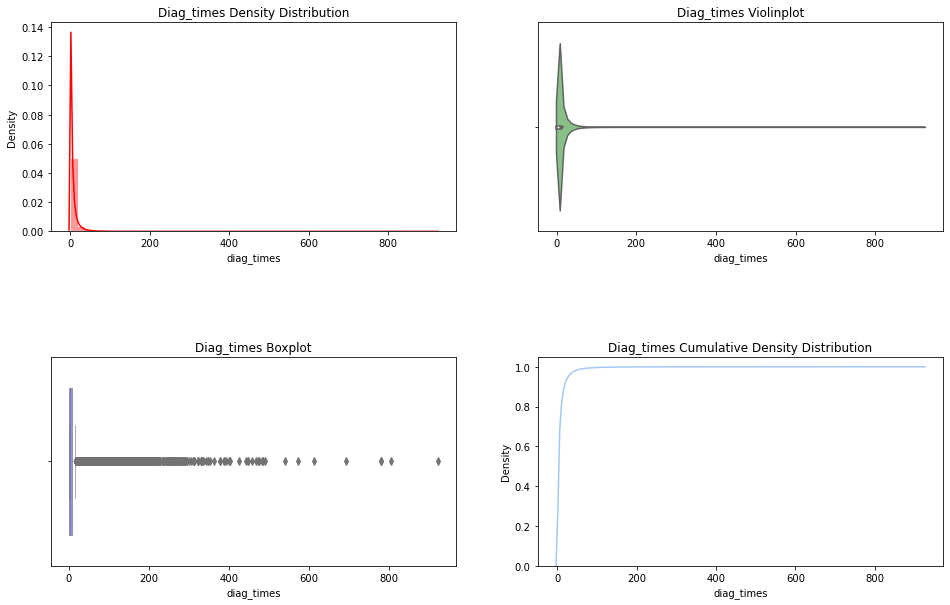

In [380]:
### from the charts we can see that the skewness of the data is very large
### that is because there are 24972 large outliers affecting the distribution of the data
### we will make some adjustment for this distribution later in this case study
plot_summary(diag_time_count, 'diag_times')

5 Point Summary of Diag_counts Attribute:
Diag_counts(min) : 0
Q1                    : 1.0
Q2(Median)            : 3.0
Q3                    : 6.0
Diag_counts(max) : 411
Total number of outliers in diag_counts distribution: 17424.


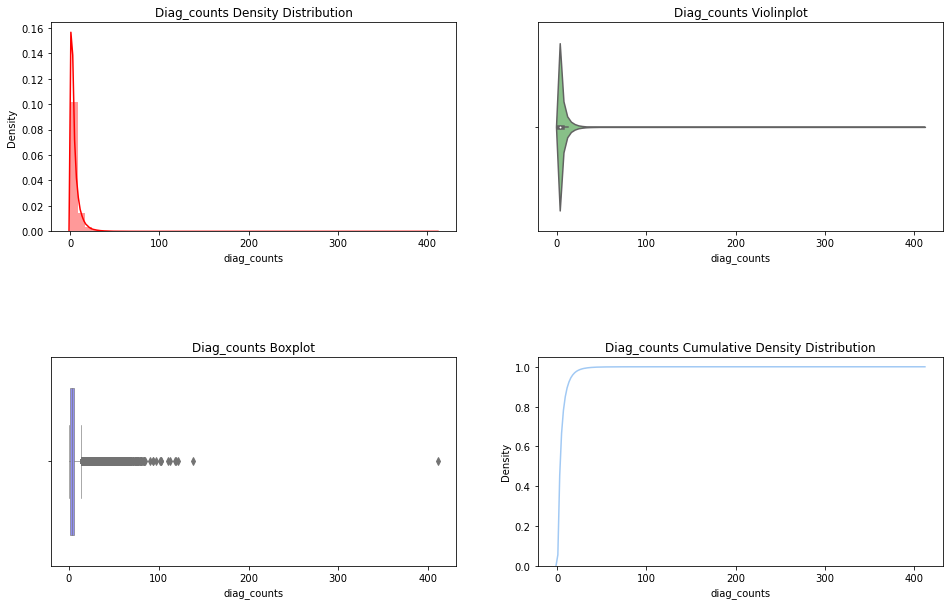

In [382]:
plot_summary(diag_time_count, 'diag_counts')
### very similar situation compared to 'diag_times'
### 17424 outliers. Maximum is 411, which seems very unusual (diagnosed with 411 different health issues)

## Explore the second dataset - ccs_data
* Check shape, info, and datatype, na values
* Explore unique ccs_1_desc categories

In [415]:
summary_data(ccs_data)
### 72167 entries, all data in ccs_data is object type

--------------------------------------Head---------------------------------------
   diag                                          diag_desc  \
0  A000  Cholera due to Vibrio cholerae 01, biovar chol...   
1  A001    Cholera due to Vibrio cholerae 01, biovar eltor   
2  A009                               Cholera, unspecified   

                         ccs_1_desc                   ccs_2_desc  \
0  Diseases of the digestive system  Intestinal infection [135.]   
1  Diseases of the digestive system  Intestinal infection [135.]   
2  Diseases of the digestive system  Intestinal infection [135.]   

             ccs_3_desc  
0  Intestinal infection  
1  Intestinal infection  
2  Intestinal infection  
--------------------------------------shape--------------------------------------
(72167, 5)
--------------------------------------info--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72167 entries, 0 to 72166
Data columns (total 5 columns):
 #   Colum

In [106]:
ccs_data.isnull().sum()
### there is no NA values for ccs data

diag          0
diag_desc     0
ccs_1_desc    0
ccs_2_desc    0
ccs_3_desc    0
dtype: int64

In [283]:
### we want to focus on exploring the ccs_1_desc column. we aim to find out how many unique categories do we have here
print(ccs_data.ccs_1_desc.unique())
### count how many unique categories for each ccs description column
for item in ['ccs_1_desc','ccs_2_desc','ccs_3_desc']:
    length_unique = len(pd.unique(ccs_data[item]))
    print(f'there are {length_unique} unique categories for {item} column')
### we can see that ccs_1_desc is the most broad description for a certain type of disease

['Diseases of the digestive system'
 'Diseases of the nervous system and sense organs'
 'Infectious and parasitic diseases' 'Diseases of the respiratory system'
 'Diseases of the musculoskeletal system and connective tissue'
 'Diseases of the skin and subcutaneous tissue'
 'Certain conditions originating in the perinatal period'
 'Complications of pregnancy; childbirth; and the puerperium'
 'Diseases of the circulatory system'
 'Diseases of the genitourinary system'
 'Symptoms; signs; and ill-defined conditions and factors influencing health status'
 'Neoplasms' 'Diseases of the blood and blood-forming organs'
 'Injury and poisoning'
 'Endocrine; nutritional; and metabolic diseases and immunity disorders'
 'Congenital anomalies' 'Mental Illness'
 'Residual codes; unclassified; all E codes [259. and 260.]']
there are 18 unique categories for ccs_1_desc column
there are 136 unique categories for ccs_2_desc column
there are 283 unique categories for ccs_3_desc column


## Explore the third dataset - drug_data
* Check shape, info, and datatype, na values
* Calculate how many times each member has been prescribed -> prescribe_times
* Calculate how many different drugs has been prescribed to a member -> drug_counts
* Calculate how many different categorues of drugs has been prescribed to a member -> drug_cat_counts
* Explore unique drugs categories counts and plot distributions for new created columns

In [417]:
summary_data(drug_data)
### 3005934 entries, 'member_id' and 'drug_category' are object type.

--------------------------------------Head---------------------------------------
             record_id member_id    date_svc          ndc  \
0  4115084976453758912  M0023556  2016-05-08  51285040702   
1  1750642805638674193  M0087538  2016-12-05  50474080303   
2  5543689263541245391  M0049608  2018-01-18      3089421   

                              drug_category                   drug_group  \
0                                 Estrogens                    Estrogens   
1  Antiparkinson and Related Therapy Agents  Antiparkinson Dopaminergics   
2                            Anticoagulants  Direct Factor Xa Inhibitors   

                               drug_class  
0                               Estrogens  
1  Nonergoline Dopamine Receptor Agonists  
2             Direct Factor Xa Inhibitors  
--------------------------------------shape--------------------------------------
(3005934, 7)
--------------------------------------info--------------------------------------
<class 'pandas.c

In [384]:
print(len(pd.unique(drug_data.drug_category)))
## there are 92 unique drug categories

92


In [385]:
### drugs prescribed to each member
member_pres_time = drug_data.groupby('member_id').size().reset_index(name='prescribe_times')
a = drug_data.groupby(['member_id','ndc']).size()
member_drug_counts_data = a.groupby('member_id').size().reset_index(name='drug_counts')
b = drug_data.groupby(['member_id','drug_category']).size()
member_drug_cat_counts = b.groupby('member_id').size().reset_index(name='drug_cat_counts')
c = member_pres_time.merge(member_drug_counts_data, on='member_id', how='left')
member_drug_sum = c.merge(member_drug_cat_counts, on='member_id', how='left')


In [386]:
member_drug_sum.head()

,member_id,prescribe_times,drug_counts,drug_cat_counts
0,M0000001,1,1,1
1,M0000002,4,4,3
2,M0000003,1,1,1
3,M0000004,2,1,1
4,M0000005,3,3,2


In [387]:
member_drug_sum.isnull().sum()
### no na values for this new created dataset

member_id          0
prescribe_times    0
drug_counts        0
drug_cat_counts    0
dtype: int64

5 Point Summary of Prescribe_times Attribute:
Prescribe_times(min) : 1
Q1                    : 2.0
Q2(Median)            : 5.0
Q3                    : 13.0
Prescribe_times(max) : 669
Total number of outliers in prescribe_times distribution: 25443.


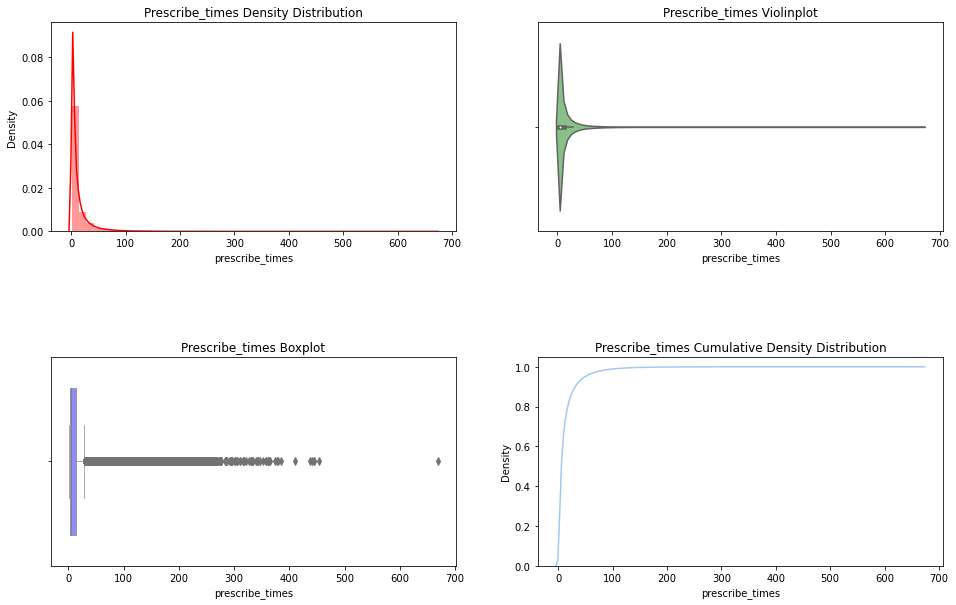

In [391]:
## plot distribution on how many times member has been prescribed with drugs
plot_summary(member_drug_sum,'prescribe_times')
### from the charts we can see that the skewness of the data is very large
### that is because there are 25443 large outliers affecting the distribution of the data
### Q1 Q2 Q3 seem to be in normal ranges, which is good at this moment
### we might make some adjustment for this distribution later in this case study if necessary

5 Point Summary of Drug_counts Attribute:
Drug_counts(min) : 1
Q1                    : 2.0
Q2(Median)            : 4.0
Q3                    : 7.0
Drug_counts(max) : 121
Total number of outliers in drug_counts distribution: 19219.


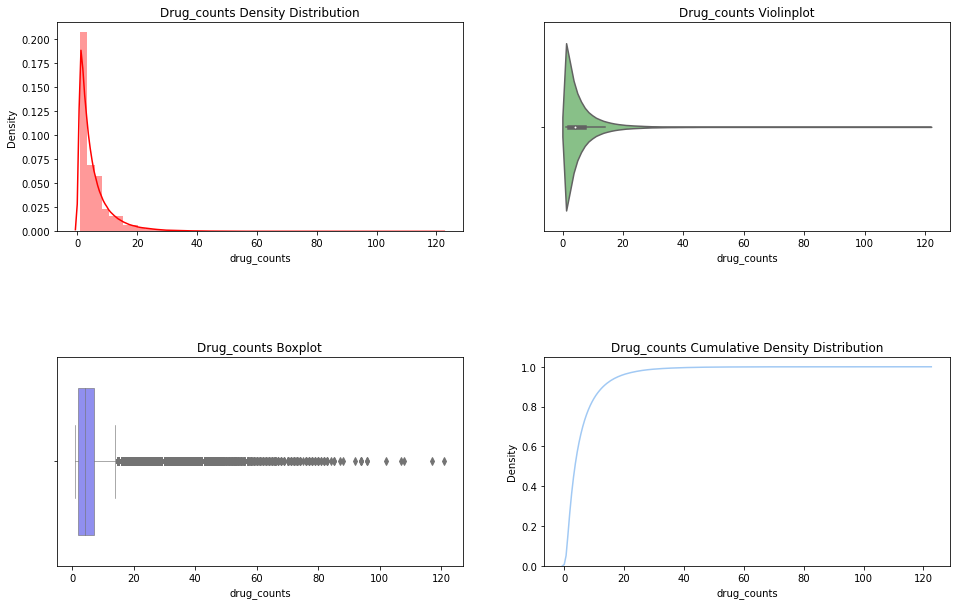

In [392]:
plot_summary(member_drug_sum,'drug_counts')
### there are 19219 large outliers affecting the distribution of the data
### Q1 Q2 Q3 seem to be in normal ranges
### we might make some adjustment for this distribution later in this case study if necessary

5 Point Summary of Drug_cat_counts Attribute:
Drug_cat_counts(min) : 1
Q1                    : 1.0
Q2(Median)            : 3.0
Q3                    : 5.0
Drug_cat_counts(max) : 35
Total number of outliers in drug_cat_counts distribution: 10282.


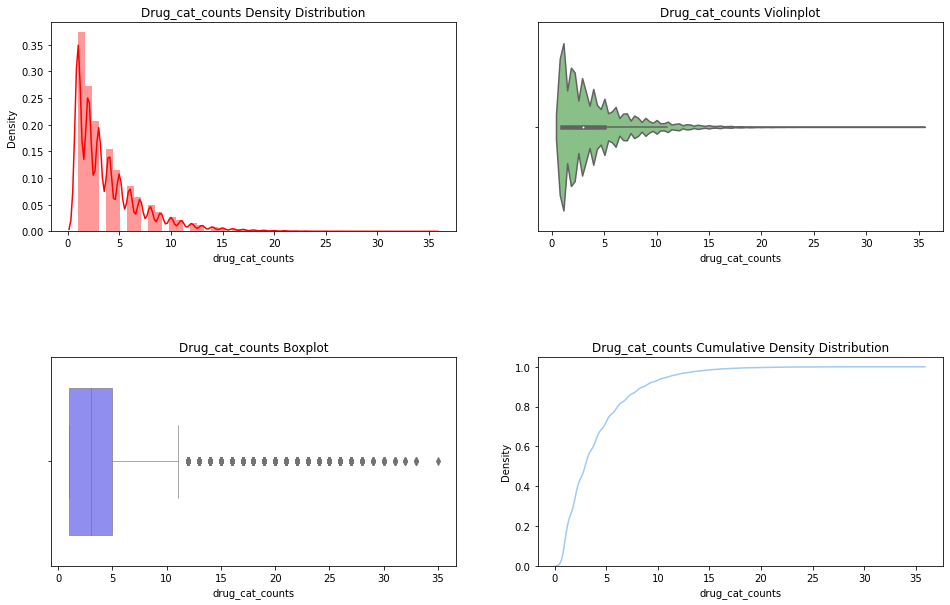

In [396]:
plot_summary(member_drug_sum,'drug_cat_counts')
### skew to the right with 10282 outliers (smaller amount compared to other variables)
### Q1 Q2 Q3 seem to be in normal ranges
### drug_cat_counts variable might be useful for our characterizing process

## Explore two datasets together - merging diag and ccs
* merging diag and ccs
* calculate count of different categories (ccs_1_desc) has the member got diagnosed
* plot distributions for the count

In [395]:
merge_data = diag_data_clean.merge(ccs_data, on='diag', how='left')
member_cat_freq = merge_data.groupby(['member_id','ccs_1_desc']).size().reset_index(name='cat_freq')
member_cat_count = member_cat_freq.groupby('member_id').size().reset_index(name='ccs_cat_count')
member_diag_sum = diag_time_count.merge(member_cat_count, on='member_id', how='left')
member_diag_sum['ccs_cat_count'] = member_diag_sum['ccs_cat_count'].fillna(0).astype(int)
member_diag_sum.head(3)

,member_id,diag_times,diag_counts,ccs_cat_count
0,M0000001,15,6,3
1,M0000002,6,6,4
2,M0000003,2,1,1


5 Point Summary of Ccs_cat_count Attribute:
Ccs_cat_count(min) : 0
Q1                    : 1.0
Q2(Median)            : 2.0
Q3                    : 4.0
Ccs_cat_count(max) : 18
Total number of outliers in ccs_cat_count distribution: 5984.


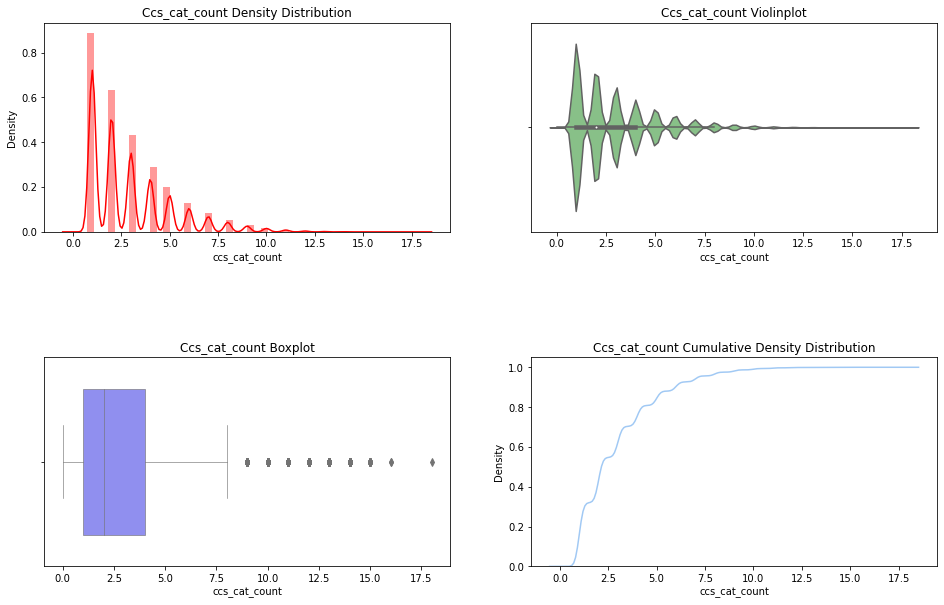

In [398]:
plot_summary(member_diag_sum,'ccs_cat_count')
### skew to the right with 5984 outliers (very small amount compared to other variables)
### Q1 Q2 Q3 seem to be in normal ranges
### this ccs_cat_count might be useful for our charectorizing process

## Combining member_diag_sum with member_drug_sum
* pick up useful and robust variables for the process of characterizing
* calculate the proportion of drug_cat_counts over ccs_cat_count -> drug_diag_cat_proportion
* plot the distribution of drug_diag_cat_proportion

In [400]:
member_diag_drug_combined = member_diag_sum.merge(member_drug_sum, on='member_id', how = 'left')
for item in ['prescribe_times', 'drug_counts', 'drug_cat_counts']:
    member_diag_drug_combined[item] = member_diag_drug_combined[item].fillna(0).astype(int)
member_diag_drug_combined.head()

,member_id,diag_times,diag_counts,ccs_cat_count,prescribe_times,drug_counts,drug_cat_counts
0,M0000001,15,6,3,1,1,1
1,M0000002,6,6,4,4,4,3
2,M0000003,2,1,1,1,1,1
3,M0000004,2,2,2,2,1,1
4,M0000005,2,2,1,3,3,2


In [404]:
### calculate the proportion of drug_cat_counts over ccs_cat_count -> drug_diag_cat_proportion
### 'drug_diag_cat_proportion' means the proportion of categories of drug a member gets prescribed over categories of disease a member gets diagnosed
member_diag_drug_combined['drug_diag_cat_proportion'] = member_diag_drug_combined['drug_cat_counts']/member_diag_drug_combined['ccs_cat_count']
member_diag_drug_combined.head()

,member_id,diag_times,diag_counts,ccs_cat_count,prescribe_times,drug_counts,drug_cat_counts,drug_diag_cat_proportion
0,M0000001,15,6,3,1,1,1,0.333333
1,M0000002,6,6,4,4,4,3,0.750000
2,M0000003,2,1,1,1,1,1,1.000000
3,M0000004,2,2,2,2,1,1,0.500000
4,M0000005,2,2,1,3,3,2,2.000000


In [407]:
member_diag_drug_combined.isnull().sum()
### only 7 na values found for drug_diag_cat_proportion

member_id                   0
diag_times                  0
diag_counts                 0
ccs_cat_count               0
prescribe_times             0
drug_counts                 0
drug_cat_counts             0
drug_diag_cat_proportion    7
dtype: int64

5 Point Summary of Drug_diag_cat_proportion Attribute:
Drug_diag_cat_proportion(min) : 0.0
Q1                    : 0.3333333333333333
Q2(Median)            : 1.0
Q3                    : 2.0
Drug_diag_cat_proportion(max) : 26.0
Total number of outliers in drug_diag_cat_proportion distribution: 7955.


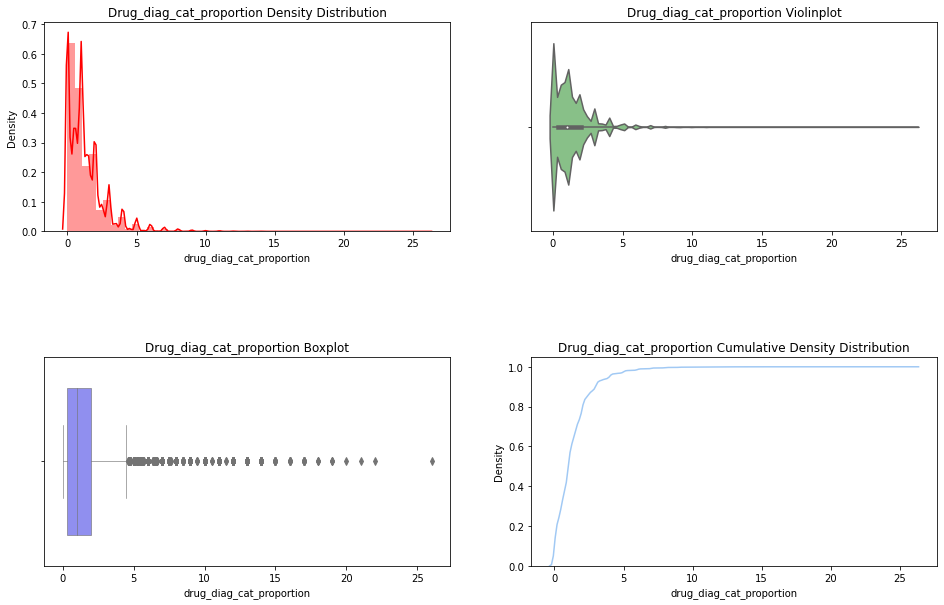

In [403]:
member_diag_drug_combined_finite = member_diag_drug_combined.loc[member_diag_drug.ccs_cat_count!=0]
plot_summary(member_diag_drug_combined_finite,'drug_diag_cat_proportion')
### outlier number is largely decreased after we make the proportion of two columns instead of using them seperately
### we will use this new variable as an essential feature for characterization

In [405]:
### make a copy of the combined data and start characterizing
member_diag_drug_cp = member_diag_drug_combined.copy()
### fill na with 0
member_diag_drug_cp['drug_diag_cat_proportion'] = member_diag_drug_cp['drug_diag_cat_proportion'].fillna(0)
member_diag_drug_cp.head()

,member_id,diag_times,diag_counts,ccs_cat_count,prescribe_times,drug_counts,drug_cat_counts,drug_diag_cat_proportion
0,M0000001,15,6,3,1,1,1,0.333333
1,M0000002,6,6,4,4,4,3,0.750000
2,M0000003,2,1,1,1,1,1,1.000000
3,M0000004,2,2,2,2,1,1,0.500000
4,M0000005,2,2,1,3,3,2,2.000000


## Start Characterizing
* Rule 1: any member who has a drug_diag_cat_proportion value that is considered outlier will be categorized as 'Unusual'. Left boundary of outlier is smaller than 0, which is not possible for proportion value. So, we only consider right boundary (Q3+1.5IQR)
    
* Rule 2: any member whose claim is not assigned with ccs category (ccs_cat_count = 0) will be categorized as 'Unusual'
* Rule 3: any member who has a drug_diag_cat_proportion value that is larger than 0.5 but smaller than outlier limit value will be categorized as 'Enough Care'
* Rule 4: any member who has a drug_diag_cat_proportion value that is between 0 and 0.5 will be 'Not Enough Care'

## Explanation
* when drug_diag_cat_proportion value is extremely high, it means that the drug_cat_count outcompetes ccs_cat_count. This means a member is prescribed with overloaded amount of kinds of drugs given the issues he/she has been diagnosed. This might be normal in some case (a member with cancer might be prescribed 10 categories of drugs). However, we still want to categorize member as 'Unusual' first. Further investigation can be brought up to make adjustment if necessary

* when drug_diag_cat_proportion value is low (like under 50%), it means that this member diagnosed with certain categories of disease but he/she only prescribed with limit categories of prescriptions, which is usually not enough.

* when drug_diag_cat_proportion value is 0, it means drug_cat_count is 0 and it means that member is diagnosed with some issues but has not been prescribed with any drugs. We categorize this type of member as 'Not Enough Care'. 

* when drug_diag_cat_proportion value is lying between 0.5 and 4.5, we label this member as 'Enough Care' at the moment. We might later adjust the boundary values slightly to better train/fit the model if necessary. 

In [408]:
### design conditions to create 'Health_Status' variable
proportion_q1 = member_diag_drug_cp['drug_diag_cat_proportion'].quantile(0.25)
proportion_q3 = member_diag_drug_cp['drug_diag_cat_proportion'].quantile(0.75)
proportion_IQR = proportion_q3 - proportion_q1
outlier_maxrange = proportion_q3 + 1.5*proportion_IQR

### when the proportion is inf, it means ccs_cat_count = 0
conditions = [
    ((member_diag_drug_cp['drug_diag_cat_proportion']>=outlier_maxrange))|(member_diag_drug_cp['drug_diag_cat_proportion']=='inf'),
    ((member_diag_drug_cp['drug_diag_cat_proportion']<outlier_maxrange)) &(member_diag_drug_cp['drug_diag_cat_proportion']>=0.5),
    (member_diag_drug_cp['drug_diag_cat_proportion']<0.5)
    ]
values = ['Unusual', 'Enough Care', 'Not Enough Care']
member_diag_drug_cp['Health_Status'] = np.select(conditions, values)

member_diag_drug_cp.head()

,member_id,diag_times,diag_counts,ccs_cat_count,prescribe_times,drug_counts,drug_cat_counts,drug_diag_cat_proportion,Health_Status
0,M0000001,15,6,3,1,1,1,0.333333,Not Enough Care
1,M0000002,6,6,4,4,4,3,0.750000,Enough Care
2,M0000003,2,1,1,1,1,1,1.000000,Enough Care
3,M0000004,2,2,2,2,1,1,0.500000,Enough Care
4,M0000005,2,2,1,3,3,2,2.000000,Enough Care


In [409]:
member_diag_drug_cp['Health_Status'].value_counts()

Enough Care        171096
Not Enough Care     65467
Unusual              8603
Name: Health_Status, dtype: int64

## Building predicting model given only drug data
* logistic regression model
* decision tree model

In [414]:
### only keep necessary features when splitting and training data 
### - here we keep 'prescribe_times' ,'drug_counts', 'drug_cat_counts' since they can be generated by drug data only and they can represent a member's drug usage
### turn Health status columns as category type
member_drug_only = member_diag_drug_cp.drop(['member_id','diag_times','diag_counts','ccs_cat_count','drug_diag_cat_proportion'], axis=1)
member_drug_only.Health_Status = pd.Categorical(member_drug_only.Health_Status)
member_drug_only.head()

,prescribe_times,drug_counts,drug_cat_counts,Health_Status
0,1,1,1,Not Enough Care
1,4,4,3,Enough Care
2,1,1,1,Enough Care
3,2,1,1,Enough Care
4,3,3,2,Enough Care


In [367]:
## Start training the data with drug only data
## Since the 'Health Status' is not fully balanced (enough > not enough > unusual), we will use StratifiedShuffleSplit method to split the data
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

random_state = 42
split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=random_state)
for train_index, test_index in split.split(member_drug_only, member_drug_only["Health_Status"]):
    strat_train_set = member_drug_only.loc[train_index]
    strat_test_set = member_drug_only.loc[test_index]

X_train_strat = strat_train_set.drop('Health_Status', axis = 1)
y_train_strat = strat_train_set.Health_Status
X_test_strat = strat_test_set.drop('Health_Status', axis = 1)
y_test_strat = strat_test_set.Health_Status

In [371]:
## using logistic regression model
lr = LogisticRegression()
lr.fit(X_train_strat, y_train_strat)
lr.score(X_test_strat,y_test_strat)

0.902638985193947

In [372]:
## using cross validation to calculate mean score for the model
cv = cross_val_score(lr,X_train_strat,y_train_strat,cv=5)
print(cv)
print(cv.mean())

[0.90251612 0.90221021 0.90404324 0.90243716 0.90276857]
0.9027950607946952


In [412]:
### using decision tree classifier
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train_strat, y_train_strat)
dt.score(X_test_strat,y_test_strat)

0.9005995839621487

In [413]:
## using cross validation to calculate mean score for the model
cv = cross_val_score(dt,X_train_strat,y_train_strat,cv=5)
print(cv)
print(cv.mean())

[0.90177684 0.89917659 0.90210575 0.90006628 0.90088207]
0.900801504341891


## What have been achieved in this case study
* Understood diag, ccs, drug datasets information, statistics, distributions
* Defined categorizing methodology for members
    * Enough Care
    * Not Enough Care
    * Unsual
* Made simple predicting models based on the Health Status column and drug data columns
    * Logistic Regression Model (score **0.9027**)
    * Decision Tree Model (score **0.9008**)

## Next steps after this study

* If given more time, we want to further slightly adjust the characterizing rules to make more defined categories
* Further defining unusual patterns for a member (some of the unusual patterns can actually be defined as 'enough care' or even 'Not enough care'- cancer case as we have discussed)
* Adding time series analytics (can a member turn from not enough to enough over time? Or the other way around - not good for business if happened)
* Further tuning predicting models to make even better predictions
* Try other advanced classifier to evaluate the predicting model
* We also want to focus on understanding whether a member is treated with the effective medication on the health issues - diag_code and ndc code matching with scores